In [1]:
import pandas as pd
import pickle
import weighted_sentiment_functions_final as wsff
import stock_price_calculation_trials as spct
from datetime import datetime

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
all_data = pd.read_csv('sample_data_modified.csv', sep='.@', header=None, names=['DELETE', 'CIK', 'TICKER', 'DATE', 'TEXT'], dtype={'CIK': object}, engine='python', parse_dates=[3], infer_datetime_format=True, encoding='utf-8')
all_data.head()

,DELETE,CIK,TICKER,DATE,TEXT
0,NaN,0000002488,AMD,2019-02-08,Our 2018 financial results demonstrate the suc...
1,NaN,0001091667,CHTR,2019-01-31,We are the second largest cable operator in th...
2,NaN,0001467858,GM,2010-04-07,Over time as Old GM’s market share declined in...


In [3]:
new_all_data = all_data.drop(['DELETE'], axis=1)
new_all_data.head()

,CIK,TICKER,DATE,TEXT
0,0000002488,AMD,2019-02-08,Our 2018 financial results demonstrate the suc...
1,0001091667,CHTR,2019-01-31,We are the second largest cable operator in th...
2,0001467858,GM,2010-04-07,Over time as Old GM’s market share declined in...


In [4]:
# load the trained classifier model from disk
filename = 'finalised_classifier_model.sav'
model = pickle.load(open(filename, 'rb'))

To-do: Might need to modify this, instead round each value maybe?
In regular sent analysis you get 0, 0.5, 1. With averaging justifications you get between 0 and 1, i.e. scaled/weighted.
Below is more like weighted mode aggregated. Whereas above 'weighted' function is like weighted mean aggregated.
But mode doesn't make much sense because it gets rid of the weight, so it is more like checking if 5 mined justifications can
capture the full sentiment of the entire document.
Read what you wrote in your thesis and then clarify all these sentiment score terms below!!!!!!

In [6]:
weighted_sentiments = []
for i, row in new_all_data.iterrows():
    weighted_sentiment = wsff.get_weighted_sentiment(row['TEXT'], model, clustering_model='Agglomerative')
    weighted_sentiments.append(weighted_sentiment)
print(weighted_sentiments)
new_all_data['weighted_sentiments'] = weighted_sentiments

unweighted_sentiments = []
for i, row in new_all_data.iterrows():
    unweighted_sentiment = wsff.get_unweighted_sentiment(row['TEXT'], model, clustering_model='Agglomerative')
    unweighted_sentiments.append(unweighted_sentiment)
print(unweighted_sentiments)
new_all_data['unweighted_sentiments'] = unweighted_sentiments

[0.80000000000000004, 0.90000000000000002, 0.80000000000000004]
[1.0, 1.0, 1.0]


In [7]:
full_sentiments_mean = []

for i, row in new_all_data.iterrows():
    full_sentiment_mean = wsff.get_full_sentiment_mean(row['TEXT'], model)
    full_sentiments_mean.append(full_sentiment_mean)
print(full_sentiments_mean)
new_all_data['full_mean'] = full_sentiments_mean

full_sentiments_mean_unrounded = []

for i, row in new_all_data.iterrows():
    full_sentiment_mean_unrounded = wsff.get_full_sentiment_mean_unrounded(row['TEXT'], model)
    full_sentiments_mean_unrounded.append(full_sentiment_mean_unrounded)
print(full_sentiments_mean_unrounded)
new_all_data['full_mean_unrounded'] = full_sentiments_mean_unrounded

full_sentiments_mode = []

for i, row in new_all_data.iterrows():
    full_sentiment_mode = wsff.get_full_sentiment_mode(row['TEXT'], model)
    full_sentiments_mode.append(full_sentiment_mode)
print(full_sentiments_mode)
new_all_data['full_mode'] = full_sentiments_mode

[1.0, 1.0, 1.0]
[0.9285714285714286, 0.96153846153846156, 0.95238095238095233]
[1.0, 1.0, 1.0]


In [8]:
new_all_data.head()

,CIK,TICKER,DATE,TEXT,weighted_sentiments,unweighted_sentiments,full_mean,full_mean_unrounded,full_mode
0,0000002488,AMD,2019-02-08,Our 2018 financial results demonstrate the suc...,0.8,1.0,1.0,0.928571,1.0
1,0001091667,CHTR,2019-01-31,We are the second largest cable operator in th...,0.9,1.0,1.0,0.961538,1.0
2,0001467858,GM,2010-04-07,Over time as Old GM’s market share declined in...,0.8,1.0,1.0,0.952381,1.0


Trial outputs for all the below stock calculations:
1:
[23.049999237060547, 331.04998779296875, 26.155519485473633]
[Timestamp('2019-02-08 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2010-11-18 00:00:00')]

2:
[52.259998321533203, 517.46002197265625, 16.585308074951172]
[Timestamp('2020-02-10 00:00:00'), Timestamp('2020-01-31 00:00:00'), Timestamp('2011-11-18 00:00:00')]
[27.090000152587891, 371.19000244140625, 27.930322647094727]
[Timestamp('2019-05-08 00:00:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2011-02-18 00:00:00')]

3:
[126.72451215316249, 56.308727096605168, -36.589643787566928]
[17.527119519516933, 12.125061509907129, 6.7855779450558877]

In [9]:
def get_current_stock_price_date(ticker, date):
    given_date = date
    while True:
        try:
            stock_price = spct.get_stock_adj_close(ticker, given_date)
            break
        except KeyError:
            given_date = spct.add_days(given_date,1)
    return given_date, stock_price

stock_prices = []
given_dates = []


    
for i, row in new_all_data.iterrows():
    given_date, stock_price = get_current_stock_price_date(row['TICKER'], row['DATE'])
    stock_prices.append(stock_price)
    given_dates.append(given_date)
    
print(stock_prices)
print(given_dates)

[23.049999237060547, 331.04998779296875, 26.155519485473633]
[Timestamp('2019-02-08 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2010-11-18 00:00:00')]


In [10]:
# To-do: create 6 month window as well.
stock_prices_next_year = []
given_dates_next_year = []
stock_prices_three_months = []
given_dates_three_months = []

for i, row in new_all_data.iterrows():
    date_one_year = spct.add_years(given_dates[i], 1)
    given_date, stock_price = get_current_stock_price_date(row['TICKER'], date_one_year)
    stock_prices_next_year.append(stock_price)
    given_dates_next_year.append(given_date)
    
for i, row in new_all_data.iterrows():
    date_three_months = spct.add_months(given_dates[i], 3)
    given_date, stock_price = get_current_stock_price_date(row['TICKER'], date_three_months)
    stock_prices_three_months.append(stock_price)
    given_dates_three_months.append(given_date)

print(stock_prices_next_year)
print(given_dates_next_year)
print(stock_prices_three_months)
print(given_dates_three_months)

[52.259998321533203, 517.46002197265625, 16.585308074951172]
[Timestamp('2020-02-10 00:00:00'), Timestamp('2020-01-31 00:00:00'), Timestamp('2011-11-18 00:00:00')]
[27.090000152587891, 371.19000244140625, 27.930322647094727]
[Timestamp('2019-05-08 00:00:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2011-02-18 00:00:00')]


In [11]:
percent_changes_one_year = []
percent_changes_three_months = []

for old, new in zip(stock_prices, stock_prices_next_year):
    change = spct.percent_change(old,new)
    percent_changes_one_year.append(change)
    
for old, new in zip(stock_prices, stock_prices_three_months):
    change = spct.percent_change(old,new)
    percent_changes_three_months.append(change)

new_all_data['% change 1 year'] = percent_changes_one_year
new_all_data['% change 3 months'] = percent_changes_three_months

print(percent_changes_one_year)
print(percent_changes_three_months)

[126.72451215316249, 56.308727096605168, -36.589643787566928]
[17.527119519516933, 12.125061509907129, 6.7855779450558877]


In [12]:
new_all_data.head()

,CIK,TICKER,DATE,TEXT,weighted_sentiments,unweighted_sentiments,full_mean,full_mean_unrounded,full_mode,% change 1 year,% change 3 months
0,0000002488,AMD,2019-02-08,Our 2018 financial results demonstrate the suc...,0.8,1.0,1.0,0.928571,1.0,126.724512,17.527120
1,0001091667,CHTR,2019-01-31,We are the second largest cable operator in th...,0.9,1.0,1.0,0.961538,1.0,56.308727,12.125062
2,0001467858,GM,2010-04-07,Over time as Old GM’s market share declined in...,0.8,1.0,1.0,0.952381,1.0,-36.589644,6.785578


Choosing spearmean versus pearson correlation:
'I noted in a comment to the post that usually spearmanr() is used for ranks and it does not seem like you are correlating ranked data. I'm making that assessment based on non-integral values of the 2 sequences-usually ranks are non-negative integral values.

Given the second issue (as it seems) I'd recommend using pearsonr(). Provided your version of scipy is 1.3.X or greater, the error message is informative and tells you exactly this issue:'

Note: Set p-value to 0.05 or less to be statistically significant. 
'The null hypothesis is that the two variables are uncorrelated. The p-value is a number between zero and one that represents the probability that your data would have arisen if the null hypothesis were true.'

In [16]:
# To-do: format printed lines with % stuff to make it more organised, google how to print with even spacing between
from scipy import special, stats

def logit_correlate(sentiments, percent_changes):
    normalised_sentiments = special.logit(sentiments)
    r, p_value = stats.pearsonr(normalised_sentiments, percent_changes)
    return r, p_value

for sentiment in ['weighted_sentiments', 'unweighted_sentiments', 'full_mean', 'full_mean_unrounded', 'full_mode']:
    r_1yr, p_value_1yr = logit_correlate(new_all_data[sentiment], new_all_data['% change 1 year'])
    print(sentiment, '1 year', 'r=', r_1yr, 'p=', p_value_1yr)
print('\n')
for sentiment in ['weighted_sentiments', 'unweighted_sentiments', 'full_mean', 'full_mean_unrounded', 'full_mode']:
    r_3month, p_value_3month = logit_correlate(new_all_data[sentiment], new_all_data['% change 3 months'])
    print(sentiment, '3 months', 'r=', r_3month, 'p=', p_value_3month)
    

weighted_sentiments 1 year r= 0.0792308577004 p= 0.949507146749
unweighted_sentiments 1 year r= nan p= nan
full_mean 1 year r= nan p= nan
full_mean_unrounded 1 year r= -0.585580396202 p= 0.601733300771
full_mode 1 year r= nan p= nan


weighted_sentiments 3 months r= -0.00336331316511 p= 0.997858844302
unweighted_sentiments 3 months r= nan p= nan
full_mean 3 months r= nan p= nan
full_mean_unrounded 3 months r= -0.650523242444 p= 0.549099291822
full_mode 3 months r= nan p= nan


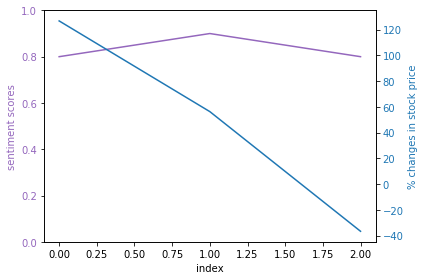

In [19]:
# To-do: maybe leave x axis unlabelled as it means nothing.
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = new_all_data.index
data1 = new_all_data['weighted_sentiments']
data2 = new_all_data['% change 1 year']

fig, ax1 = plt.subplots()

color = 'tab:purple'
ax1.set_xlabel('index')
ax1.set_ylabel('sentiment scores', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('% changes in stock price', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()